# CoxPH-EWAS unadjusted in COG trials with OS and EFS as outcome

```{contents}
```

## Load and process clinical data

In [6]:
import pandas as pd

input_path = '../Data/Intermediate_Files/'
clinical_data_path = '../Data/Raw_Data/Clinical_Data/'
output_path = '../Data/Processed_Data/'


df_methyl = pd.read_pickle(
    input_path+'df_batch_uncorrected.pkl').sort_index()

print(
    f' Dataset (df) contains {df_methyl.shape[1]} columns (5mC nucleotides/probes) and {df_methyl.shape[0]} rows (samples).')

# Import functions to clean up clinical data
from FM_Functions.Clinical_Data_CleanUp import *

# Call functions to merge, index and clean clinical data files
labels_0531         = clean_cog       (merge_index_0531())
labels_1031         = clean_cog       (merge_index_1031())
labels_aml05        = clean_aml05     (merge_index_aml05())
labels_beataml      = clean_beataml   (merge_index_beataml())
labels_amltcga      = clean_amltcga   (merge_index_amltcga())
labels_nordic_all   = clean_nordic_all(merge_index_nordic_all())
labels_mds_taml     = clean_mds_taml  (merge_index_mds_taml())
labels_all_graal    = clean_all_graal (merge_index_all_graal())
labels_target_all   = clean_target_all(merge_index_target_all())

# Combine all clinical data labels into one dataframe
labels_combined = pd.concat([labels_aml05, labels_beataml,
                         labels_0531, labels_amltcga, labels_1031,
                        labels_nordic_all, labels_mds_taml,
                        labels_all_graal,labels_target_all], axis=0, join='outer')

# Remove samples that are not in the methyl dataset
df_labels = labels_combined.loc[labels_combined.index.isin(df_methyl.index)].sort_index()

 Dataset (df) contains 333352 columns (5mC nucleotides/probes) and 3330 rows (samples).


/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Remove samples based on certain clinical features

### Select samples from AAML1031, 0531, and 03P1 clinical trials

In [7]:
df1 = df_labels[df_labels['Clinical Trial'].isin(['AAML0531', 'AAML1031', 'AAML03P1'])]

print(
    f'{df_labels.shape[0]-df1.shape[0]} samples were removed. {df1.shape[0]} samples remaining.')


2049 samples were removed. 1281 samples remaining.


### Select diagnostic bone marrow samples only

In [8]:
df2 = df1[df1['Sample Type'].isin(
    ['Diagnosis', 'Primary Blood Derived Cancer - Bone Marrow'])]

print(
    f'{df1.shape[0]-df2.shape[0]} samples were removed. {df2.shape[0]} samples remaining.')

350 samples were removed. 931 samples remaining.


### Remove duplicate samples

In [9]:
df3 = df2[~df2['Patient_ID'].duplicated(keep='last')]

print(
    f'{df2.shape[0]-df3.shape[0]} samples were removed. {df3.shape[0]} samples remaining.')


7 samples were removed. 924 samples remaining.


### Match samples in clinical data to samples in methylation data

In [10]:
# Match samples in clinical data to samples in methylation data
df_methyl_filtered = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 1:]

print('Samples in clinical data matched to samples in methylation data.')

Samples in clinical data matched to samples in methylation data.


## Transform to M-values

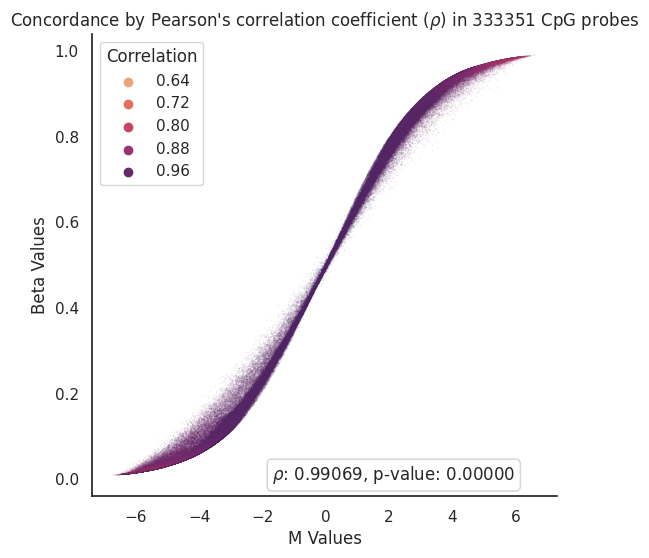

In [11]:
import math
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

x_train_m = df_methyl_filtered.apply(np.vectorize(beta2m))

# Get correlation between Beta and M Values
corr = x_train_m.corrwith(df_methyl_filtered, axis=0)

# Glue them into same dataframe for vizualization purposes
beta_to_m_values = pd.concat([x_train_m.mean(),df_methyl_filtered.mean(),corr],axis=1,
                             keys=['M Values','Beta Values','Correlation'],
                             join= 'inner')

def draw_scatterplot(df,x,y,hue,s):
    
    # Define theme

    sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(6, 6))
    sns.despine(f, left=False, bottom=False)

    # Define scatterplot

    sns.scatterplot(x=x, y=y,
                    hue=hue, palette='flare', s=s,
                    sizes=(1, 8), linewidth=0, alpha=0.1,
                    data=df, ax=ax)

    # Calculate Pearson’s correlation coefficient (r)
    # and its two-tailed p-value (p)

    r,p = stats.pearsonr(df[x],df[y])

    # Annotate r and p into the plot

    plt.annotate(fr'$\rho$: {r:.5f}, p-value: {p:.5f}',
                xy=(6.0, 0.01), xycoords='data',
                ha='right', va='center',
                bbox={'boxstyle': 'round', 'facecolor': 'none',
                'edgecolor': 'lightgray'})

    # Define plot specs

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(r"Concordance by Pearson's correlation coefficient ($\rho$) in " + str(len(df)) + ' CpG probes',
               fontsize = 12) 

    # Save plot figure
    
    # plt.savefig('../Figures/Beta_to_M_Values_' + str(len(df)) + '_scatterplot' + '.png',
    #              bbox_inches='tight', dpi=300)

    return(plt.show())

draw_scatterplot(df=beta_to_m_values,x='M Values',y='Beta Values',hue='Correlation',s=1)

## Step 9. Perform batch correction

- __pyCombat__ is a Python tool for batch effects correction in high-throughput molecular data using empirical Bayes methods

- __Github__: [https://epigenelabs.github.io/pyComBat/](https://epigenelabs.github.io/pyComBat/)

- __Implementation Preprint__: [bioRxiv](https://doi.org/10.1101/2020.03.17.995431)

- __Original Paper__: [Adjusting batch effects in microarray expression data using empirical Bayes methods](https://pubmed.ncbi.nlm.nih.gov/16632515/)

In [12]:
from combat.pycombat import pycombat

# Correct batch effects in the training dataset
df_batchcorrected = pycombat(data = x_train_m.T, batch = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 0]).round(3).T

print('Succesfully corrected batch effects in the training dataset.')


Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Succesfully corrected batch effects in the training dataset.


### Evaluate batch effects

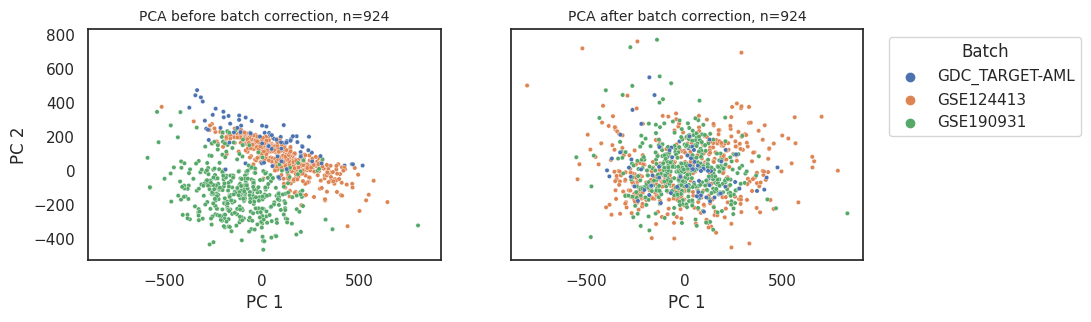

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def standardize_data(df):
    '''Standardizes the data.'''
    return StandardScaler().fit_transform(df.T)

def perform_pca(std_data):
    '''Performs PCA on standardized data.'''
    pca = PCA(n_components=2, random_state=42)
    return pca.fit_transform(std_data)

def create_principal_df(pca_data, df):
    '''Creates a DataFrame with the PCA data.'''
    principal_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'], index=df.columns)
    principal_df['hue'] = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 0]
    return principal_df

def filter_df(df, principal_df, threshold):
    '''Filters the DataFrame by removing outliers.'''
    outliers = principal_df[principal_df['PC1'] >= threshold].index
    return df.drop(outliers, axis=1)

X_std = standardize_data(df_batchcorrected.T)
principal_components = perform_pca(X_std)
pcs_batchcorrected = create_principal_df(principal_components, df_batchcorrected.T)

X_std = standardize_data(x_train_m.T)
principal_components = perform_pca(X_std)
pcs_uncorrected = create_principal_df(principal_components, x_train_m.T)

def plot_data(principal_df, non_outliers):
    '''Plots PCA data.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    
    for df, ax, title, legend in [(principal_df, ax2,
                                   'PCA after batch correction, n=' + str(principal_df.shape[0]), 'full'),
                                  (non_outliers, ax1,
                                   'PCA before batch correction, n=' + str(non_outliers.shape[0]), False)]:
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='hue', s=10, alpha=1, ax=ax, legend=legend)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Batch')
    plt.show()

plot_data(pcs_batchcorrected, pcs_uncorrected)


## Run EWAS OS with batch correction

/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/methylize/diff_meth_pos.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


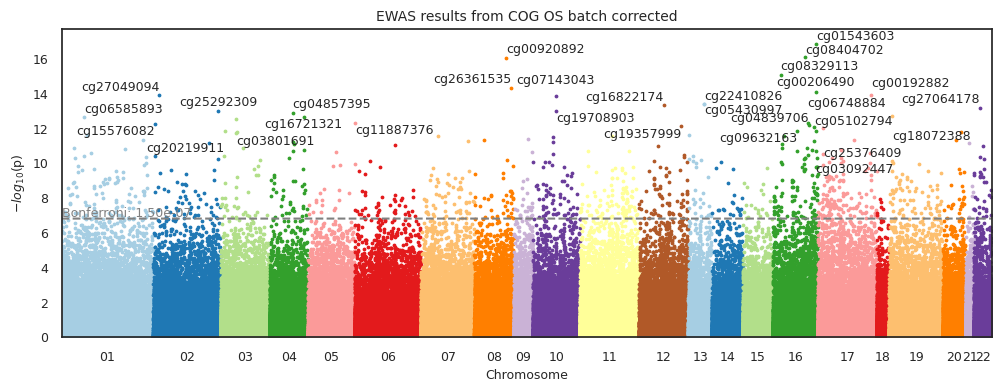

In [14]:
import methylize
import seaborn as sns
sns.set_theme(style="white")

# ewas_cog_corrected = methylize.diff_meth_pos(meth_data = df_batchcorrected,
#                                     duration = df3['os.time'],
#                                     event_observed = df3['os.evnt'],
#                                     pheno_data = df3['os.time'], # not used
#                                     covariates = False,
#                                     regression_method = "coxph",
#                                     export = 'pkl',
#                                     verbose = True,
#                                     filename=output_path + 'ewas_dmr/ewas_cog_os_batch_corrected')

ewas_cog_corrected = pd.read_pickle(output_path + 'ewas_dmr/ewas_cog_os_batch_corrected.pkl')

methylize.manhattan_plot(stats_results=ewas_cog_corrected,
                        palette='Paired',
                        save=False,
                        suggestive=False,
                        significant= False,
                        width=12,
                        height=4,
                        statsmode=False,
                        bonferroni=True,
                        fontsize=9,
                        array_type='450k',
                        explore=False,
                        border = True,
                        label_sig_probes=True,
                        fwer=0.05,
                        cohorts= " COG OS batch corrected",
                        filename='../Figures/Manhattan_Plots/ewas_os_unadjusted')


## Run EWAS EFS with batch correction

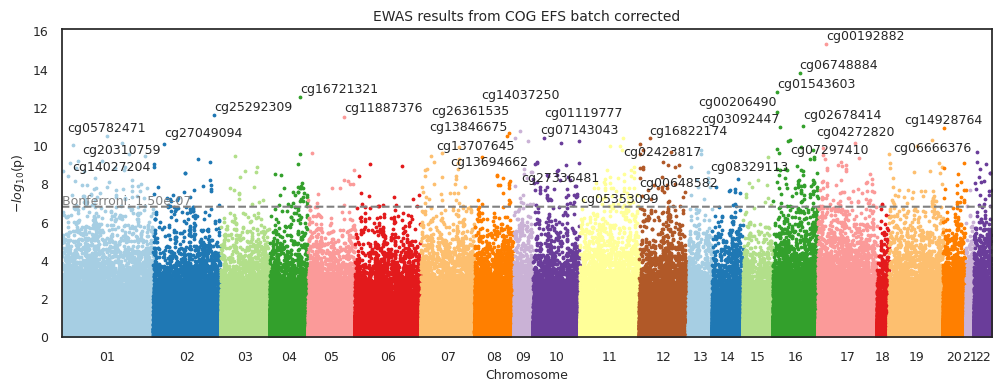

In [15]:
import methylize
import seaborn as sns
sns.set_theme(style="white")

# ewas_cog_corrected_efs = methylize.diff_meth_pos(meth_data = df_batchcorrected,
#                                     duration = df3['efs.time'],
#                                     event_observed = df3['efs.evnt'],
#                                     pheno_data = df3['efs.time'], # not used
#                                     covariates = False,
#                                     regression_method = "coxph",
#                                     export = 'pkl',
#                                     verbose = True,
#                                     filename=output_path + 'ewas_dmr/ewas_cog_efs_batch_corrected')

ewas_cog_corrected_efs = pd.read_pickle(output_path + 'ewas_dmr/ewas_cog_efs_batch_corrected.pkl')

methylize.manhattan_plot(stats_results=ewas_cog_corrected_efs,
                        palette='Paired',
                        save=False,
                        suggestive=False,
                        significant= False,
                        width=12,
                        height=4,
                        statsmode=False,
                        bonferroni=True,
                        fontsize=9,
                        array_type='450k',
                        explore=False,
                        border = True,
                        label_sig_probes=True,
                        fwer=0.05,
                        cohorts= " COG EFS batch corrected",
                        filename='../Figures/Manhattan_Plots/ewas_efs_unadjusted')


## Select probes by Bonferroni-corrected p-values (1.5*10e-7)

In [16]:
# Select rows in which `PValue` is less than 0.05/number of rows/probes (bonferroni correction)
ewas_os_top = ewas_cog_corrected[ewas_cog_corrected['PValue'] < (0.05/ewas_cog_corrected.shape[0])]
ewas_efs_top = ewas_cog_corrected_efs[ewas_cog_corrected_efs['PValue'] < (0.05/ewas_cog_corrected_efs.shape[0])]

# Get overlapping probes
ewas_top = ewas_os_top[ewas_os_top.index.isin(ewas_efs_top.index)]

# Load manifest
zhou2016_probes = pd.read_csv('../Data/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv',
                              sep='\t',index_col=0)[['chrm','start', 'end', 'GeneNames','GeneClasses', 'TranscriptIDs','CGIPosition']]

# print number of probes selected
print('Number of CpG probes selected in EWAS OS: ' + str(ewas_os_top.shape[0]))
print('Number of CpG probes selected in EWAS EFS: ' + str(ewas_efs_top.shape[0]))
print('Number of CpG probes selected in EWAS OS and EFS: ' + str(ewas_top.shape[0]))

Number of CpG probes selected in EWAS OS: 1076
Number of CpG probes selected in EWAS EFS: 593
Number of CpG probes selected in EWAS OS and EFS: 418


## Select probes by standard genome-wide significance threshold (5*10e-8)

In [17]:
## Select probes by Bonferroni-corrected p-values
# Select rows in which `PValue` is less than 0.05/1,000,000 (standard genome-wide significance threshold)
ewas_os_top = ewas_cog_corrected[ewas_cog_corrected['PValue'] < (5*10**-8)]
ewas_efs_top = ewas_cog_corrected_efs[ewas_cog_corrected_efs['PValue'] < (5*10**-8)]

# Get overlapping probes
ewas_top = ewas_os_top[ewas_os_top.index.isin(ewas_efs_top.index)]

# print number of probes selected
print('Number of CpG probes selected in EWAS OS: ' + str(ewas_os_top.shape[0]))
print('Number of CpG probes selected in EWAS EFS: ' + str(ewas_efs_top.shape[0]))
print('Number of CpG probes selected in EWAS OS and EFS: ' + str(ewas_top.shape[0]))

Number of CpG probes selected in EWAS OS: 791
Number of CpG probes selected in EWAS EFS: 431
Number of CpG probes selected in EWAS OS and EFS: 304


## Fetch gene annotation

### EWAS-OS

In [18]:
# Load manifest
zhou2016_probes = pd.read_csv('../Data/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv',
                              sep='\t',index_col=0)[['chrm','start', 'end', 'GeneNames','GeneClasses', 'TranscriptIDs','CGIPosition']]

# Get probes from Zhou et al. (2016) that are in ewasOS_un.index
ewas_os_top = zhou2016_probes.join(ewas_os_top[['PValue']],how='inner').sort_values(by='PValue')
ewas_os_top

,chrm,start,end,GeneNames,GeneClasses,TranscriptIDs,CGIPosition,PValue
cg01543603,chr16,89403132,89403134,ANKRD11;ANKRD11;ANKRD11;ANKRD11;ANKRD11;ANKRD1...,protein_coding;protein_coding;protein_coding;p...,ENST00000301030.7;ENST00000378330.5;ENST000003...,.,1.354369e-17
cg08404702,chr16,2083386,2083388,TSC2;TSC2;TSC2;TSC2;TSC2;TSC2;TSC2;TSC2;TSC2;TSC2,protein_coding;protein_coding;protein_coding;p...,ENST00000219476.6;ENST00000350773.7;ENST000003...,N_Shore,7.837118e-17
cg00920892,chr8,37874705,37874707,RAB11FIP1;RAB11FIP1;RAB11FIP1;RAB11FIP1;RAB11F...,protein_coding;protein_coding;protein_coding;p...,ENST00000287263.7;ENST00000330843.7;ENST000005...,.,8.475752e-17
cg08329113,chr16,70737238,70737240,VAC14;VAC14;VAC14;VAC14;VAC14;VAC14;VAC14,protein_coding;protein_coding;protein_coding;p...,ENST00000261776.8;ENST00000561879.1;ENST000005...,.,8.050759e-16
cg26361535,chr8,143494433,143494435,ZC3H3;ZC3H3,protein_coding;protein_coding,ENST00000262577.5;ENST00000528401.1,.,4.356361e-15
...,...,...,...,...,...,...,...,...
cg19198993,chr12,131223754,131223756,.,.,.,.,4.931295e-08
cg09269619,chr4,719389,719391,PCGF3;PCGF3;PCGF3;PCGF3;PCGF3;PCGF3;PCGF3;PCGF...,protein_coding;protein_coding;protein_coding;p...,ENST00000362003.8;ENST00000400151.5;ENST000004...,N_Shore,4.951836e-08
cg21175873,chr9,136840885,136840887,RABL6;RABL6;RABL6;RABL6;RABL6;RABL6,protein_coding;protein_coding;protein_coding;p...,ENST00000311502.10;ENST00000357466.5;ENST00000...,S_Shore,4.960181e-08
cg10535320,chr17,63831508,63831510,FTSJ3;PSMC5;PSMC5;PSMC5;PSMC5;PSMC5;PSMC5;PSMC...,protein_coding;protein_coding;protein_coding;p...,ENST00000580295.1;ENST00000310144.9;ENST000003...,S_Shelf,4.985238e-08


### EWAS-EFS

In [19]:
# Get probes from Zhou et al. (2016) that are in ewasOS_un.index
ewas_efs_top = zhou2016_probes.join(ewas_efs_top[['PValue']],how='inner').sort_values(by='PValue')
ewas_efs_top

,chrm,start,end,GeneNames,GeneClasses,TranscriptIDs,CGIPosition,PValue
cg00192882,chr17,19387806,19387808,MFAP4;MFAP4;MFAP4;MFAP4,protein_coding;protein_coding;protein_coding;p...,ENST00000299610.4;ENST00000395592.5;ENST000004...,.,4.631221e-16
cg06748884,chr16,11138900,11138902,CLEC16A;CLEC16A;CLEC16A;CLEC16A;CLEC16A,protein_coding;protein_coding;protein_coding;p...,ENST00000261657.5;ENST00000409790.4;ENST000004...,.,1.568135e-14
cg01543603,chr16,89403132,89403134,ANKRD11;ANKRD11;ANKRD11;ANKRD11;ANKRD11;ANKRD1...,protein_coding;protein_coding;protein_coding;p...,ENST00000301030.7;ENST00000378330.5;ENST000003...,.,1.543976e-13
cg16721321,chr4,1208907,1208909,CTBP1-AS;SPON2;SPON2;SPON2;SPON2;SPON2;SPON2;S...,antisense;protein_coding;protein_coding;protei...,ENST00000625256.1;ENST00000400762.6;ENST000005...,N_Shore,2.869478e-13
cg00206490,chr16,89403320,89403322,ANKRD11;ANKRD11;ANKRD11;ANKRD11;ANKRD11;ANKRD1...,protein_coding;protein_coding;protein_coding;p...,ENST00000301030.7;ENST00000378330.5;ENST000003...,.,1.780858e-12
...,...,...,...,...,...,...,...,...
cg14165772,chr1,2931066,2931068,.,.,.,S_Shore,4.901819e-08
cg16708012,chr12,108598337,108598339,TMEM119;TMEM119;TMEM119;TMEM119,protein_coding;protein_coding;protein_coding;p...,ENST00000392806.3;ENST00000547567.1;ENST000005...,.,4.910177e-08
cg26657404,chr16,85651214,85651216,GSE1;GSE1;GSE1;GSE1,protein_coding;protein_coding;protein_coding;p...,ENST00000253458.10;ENST00000393243.4;ENST00000...,S_Shore,4.930162e-08
cg04981940,chr1,1462967,1462969,ATAD3C;ATAD3C,protein_coding;protein_coding,ENST00000378785.5;ENST00000484537.2,S_Shelf,4.931577e-08


### Overlap EWAS-OS and EWAS-EFS

In [20]:
ewas_os_top2 = ewas_os_top.reset_index().reset_index().rename(columns={'level_0':'OS Rank'})\
    .set_index('index').rename(columns={'PValue':'OS PValue'})
ewas_efs_top2 = ewas_efs_top.reset_index().reset_index().rename(columns={'level_0':'EFS Rank'})\
    .set_index('index').rename(columns={'PValue':'EFS PValue'})[['EFS Rank','EFS PValue']]

# concatenate the two dataframes
ewas_top2 = pd.concat([ewas_os_top2,ewas_efs_top2],axis=1,join='inner')

# Save to csv
ewas_top2.to_csv(output_path + 'ewas_dmr/ewas_top_overlapping_probes.csv')

ewas_top2

,OS Rank,chrm,start,end,GeneNames,GeneClasses,TranscriptIDs,CGIPosition,OS PValue,EFS Rank,EFS PValue
index,,,,,,,,,,,
cg01543603,0,chr16,89403132,89403134,ANKRD11;ANKRD11;ANKRD11;ANKRD11;ANKRD11;ANKRD1...,protein_coding;protein_coding;protein_coding;p...,ENST00000301030.7;ENST00000378330.5;ENST000003...,.,1.354369e-17,2,1.543976e-13
cg08404702,1,chr16,2083386,2083388,TSC2;TSC2;TSC2;TSC2;TSC2;TSC2;TSC2;TSC2;TSC2;TSC2,protein_coding;protein_coding;protein_coding;p...,ENST00000219476.6;ENST00000350773.7;ENST000003...,N_Shore,7.837118e-17,32,1.185579e-10
cg00920892,2,chr8,37874705,37874707,RAB11FIP1;RAB11FIP1;RAB11FIP1;RAB11FIP1;RAB11F...,protein_coding;protein_coding;protein_coding;p...,ENST00000287263.7;ENST00000330843.7;ENST000005...,.,8.475752e-17,54,3.603416e-10
cg08329113,3,chr16,70737238,70737240,VAC14;VAC14;VAC14;VAC14;VAC14;VAC14;VAC14,protein_coding;protein_coding;protein_coding;p...,ENST00000261776.8;ENST00000561879.1;ENST000005...,.,8.050759e-16,21,5.440070e-11
cg26361535,4,chr8,143494433,143494435,ZC3H3;ZC3H3,protein_coding;protein_coding,ENST00000262577.5;ENST00000528401.1,.,4.356361e-15,11,2.125994e-11
...,...,...,...,...,...,...,...,...,...,...,...
cg13478045,759,chr9,134585473,134585475,.,.,.,.,4.473791e-08,108,1.606878e-09
cg08387463,760,chr8,142613185,142613187,ARC;ARC,protein_coding;protein_coding,ENST00000356613.3;ENST00000581404.1,Island,4.475284e-08,158,3.832653e-09
cg01476568,761,chr10,5692752,5692754,FAM208B;FAM208B;FAM208B;FAM208B;FAM208B;FAM208B,protein_coding;protein_coding;protein_coding;p...,ENST00000328090.8;ENST00000473789.4;ENST000004...,.,4.502326e-08,382,3.588294e-08


## Identify differentially methylated regions (DMRs)

- __Comb-p__ is a command-line tool and a python library that manipulates BED files of possibly irregularly spaced P-values and (1) calculates auto-correlation, (2) combines adjacent P-values, (3) performs false discovery adjustment, (4) finds regions of enrichment (i.e. series of adjacent low P-values) and (5) assigns significance to those regions.

- __Github__: [brentp/combined-pvalues](https://github.com/brentp/combined-pvalues)

- __Implementation Software__: [Methylize](https://life-epigenetics-methylize.readthedocs-hosted.com/en/latest/docs/diff_meth_regions.html)

- __Original Paper__: [Comb-p: software for combining, analyzing, grouping and correcting spatially correlated P-values](https://pubmed.ncbi.nlm.nih.gov/22954632/)

In [21]:
# ewas_os_dmr = methylize.diff_meth_regions(stats = ewas_cog_corrected,
#                                             manifest_or_array_type = '450k',
#                                             verbose = True,
#                                             prefix = output_path + 'ewas_dmr/ewas_cog_os_dmr',
#                                             plot=False,
#                                             annotate=True,
#                                             tissue='blood'
#                                             )

# ewas_efs_dmr = methylize.diff_meth_regions(stats = ewas_cog_corrected_efs,
#                                             manifest_or_array_type = '450k',
#                                             verbose = True,
#                                             prefix = output_path + 'ewas_dmr/ewas_cog_efs_dmr',
#                                             plot=False,
#                                             annotate=True,
#                                             tissue='blood'
#                                             )

ewas_os_dmr = pd.read_csv(output_path + 'ewas_dmr/ewas_cog_os_dmr_regions_genes.csv', index_col=0)
ewas_efs_dmr = pd.read_csv(output_path + 'ewas_dmr/ewas_cog_efs_dmr_regions_genes.csv', index_col=0)

### EWAS-OS

In [22]:
ewas_os_dmr.sort_values(by='n_probes', ascending=False)[['n_probes', 'name', 'genes', 'descriptions']].head(25)

,n_probes,name,genes,descriptions
2673,29,cg11626629,"FBXL2,STARD13-AS",| Homo sapiens F-box and leucine rich repeat ...
2408,14,cg09865015,"APBA2,LOC649352",NaN
621,9,cg04717045,NaN,NaN
516,9,cg08558873,NLRP14,Homo sapiens NLR family pyrin domain containin...
1532,8,cg02667467,OTOP2,"Homo sapiens otopetrin 2 (OTOP2), mRNA. (from ..."
72,8,cg01800926,NaN,NaN
1092,8,cg25994931,CYP26A1,Homo sapiens cytochrome P450 family 26 subfami...
2659,8,cg26978172,NaN,NaN
411,8,cg03161190,WBP1L,Homo sapiens WW domain binding protein 1 like ...
2548,8,cg15145693,CAST,"| Homo sapiens calpastatin (CAST), transcript..."


### EWAS-EFS

In [23]:
ewas_efs_dmr.sort_values(by='n_probes', ascending=False)[['n_probes', 'name', 'genes', 'descriptions']].head(25)

,n_probes,name,genes,descriptions
949,13,cg09865015,"APBA2,LOC649352",NaN
1048,10,cg22878489,NaN,NaN
275,8,cg04717045,NaN,NaN
1009,8,cg15145693,CAST,"| Homo sapiens calpastatin (CAST), transcript..."
387,7,cg21101356,NaN,NaN
545,7,cg13254898,NaN,NaN
1037,7,cg11565299,NaN,NaN
1049,7,cg16090881,NaN,NaN
216,6,cg27261733,"LSP1,PPP1R10,GNL1",| Homo sapiens G protein nucleolar 1 (putativ...
425,6,cg25994931,CYP26A1,Homo sapiens cytochrome P450 family 26 subfami...


## Standardize beta values and save top probes

In [58]:
# Select only significant probes
x = df_batchcorrected[ewas_top2.index.to_list()]

# Standardize the data
x = (x - x.mean()) / x.std()

# Save x to pickle in output_path
x.to_pickle(output_path + 'ewas_dmr/ewas_top_x.pkl')

# Print a statement saying that you have saved the data, the shape and the path
print('Succesfully saved the data in ' + output_path + 'ewas_dmr/ewas_top_x.pkl')
print('The shape of the data is ' + str(x.shape))

## Watermark

In [16]:
%load_ext watermark

In [17]:
%watermark -v -p methylize,pandas -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

methylize: 1.1.1
pandas   : 2.0.1

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

